## Here we try to extract the MGRS (Military Grid Reference System) Coordinates from the svg element.

We assume that the coordinates are created through path elements and display complex polygons as text. So we think the coordinates are just svg path elements with very long d attributes (between 3000 and 6000). After we found them we also try to reengineer the position of the element from the original svg. Therefore we look at the svg transformation from the parent elements of the specific path element which might be the coordinates. 

In the end we create a little png from the isolated svg path element and do OCR to get the Text machine readable from the svg path element. 

In [62]:
import bs4
import cairosvg
import pytesseract
from PIL import Image
import mgrs
import json
import math
import numpy as np
import cairosvg
from PIL import Image
import re
import os
from tqdm import tqdm



In [63]:
def missing_coordinates(file_id, text):
    if file_id == "2780-III":
        return ["34TBN6122", "34TBN7122"]

    elif file_id == "2783-I":
         return["34TBQ9214", "34TCQ0114"]

    elif file_id == "2984-IV":
         return["34TCQ6568", "34TCQ7468"]

    elif file_id == "2384-IV":
         return["33TWK5468", "33TWK6469"]
    elif file_id == "2680-I":
         return["33TYH2847", "33TYH3648"]
    
    
    elif file_id == "2484-IV":
         return["33TXK0168", "33TXK1169"]
    

    elif file_id == "2484-I":
         return ["33TXK2569", "33TXK3570"]

    elif file_id == "2984-III":
         return ["34TCQ6442", "34TCQ7442"]
    elif file_id == "2884-IV":
         return ["34TCQ1770", "34TCQ2770"]
    elif file_id == "2784-III":
         return ["34TBQ6943", "34TBQ7843"]
    elif file_id == "2682-III":
         return ["33TYJ0130", "33TYJ1031"]

    else:
         return text
    

In [64]:
def calculate_coordinates(path):
    parent = path.parent

    start_coordinates_path_element = ()

    while parent is not None:
        #print("Parent Element:", parent.name)
        for attribute, value in parent.attrs.items():

            if attribute == "transform":
                
               # print(f"{attribute}: {value}")
                # here we extract the start coordinate information  for the path element out of the transform attributes from the svg parent elements
                transformations = value.split("(")[-1].split(")")[0].split(",")
                # if attribute transform has 1 or 2 elements its just a relocation (the function translate) of the coordinates in either x or x and y direction
                # if attribute transform has 6 elements its the function matrix. Here is what each position does:
                # 1. scaling x coordinates
                # 2. skewing transformation alongside x axis
                # 3. skewing transformation alongside y axis
                # 4. scaling y coordinates 
                # 5. translation in x direction
                # 6. translation in y direction

                if len(transformations) == 2:
                    start_coordinates_path_element = (float(transformations[0]), float(transformations[1]))
            
                elif len(transformations) == 1 and "translate" in value:
                    start_coordinates_path_element = (start_coordinates_path_element[0] + float(transformations[0]) , start_coordinates_path_element[1])

                elif len(transformations) == 6:

                    #1. scaling x coordinates
                    start_coordinates_path_element =  (start_coordinates_path_element[0] * float(transformations[0]), start_coordinates_path_element[1])

                    #4. scaling y coordinates and 6. translate in y directio 
                    start_coordinates_path_element = (start_coordinates_path_element[0], (float(transformations[3]) * start_coordinates_path_element[1]) + float(transformations[5]) )

                elif len(transformations) == 1 and "rotate" in value:
                        
                        angle = float(transformations[0])
                        cx, cy = 0, 0
                        angle_rad = math.radians(angle)
                        cos_angle = math.cos(angle_rad)
                        sin_angle = math.sin(angle_rad)

                        x, y = start_coordinates_path_element
                        x -= cx
                        y -= cy
                        new_x = x * cos_angle - y * sin_angle + cx
                        new_y = x * sin_angle + y * cos_angle + cy
                        start_coordinates_path_element = (new_x, new_y)


                #print("neu berechnete Koordinaten: ")
                #print(start_coordinates_path_element)
        
        parent = parent.parent
    #print("Endgültige Startkoordinatne für path Element: ")
    #print(start_coordinates_path_element)
    return start_coordinates_path_element

In [65]:
def find_mgrs_coordinates(soup, file_id):

    min_length = 2000
    max_length = 6000

    svg_elements = []

    for path in soup.find_all('path'):
        d_length = len(path.get('d', ''))  # Get the length of the `d` attribute
        style = path.get('style', '')  # Get the `style` attribute
        if min_length <= d_length <= max_length and 'fill:#000000' in style:
            svg_elements.append(path)


    #military grid reference system
    mgrs_coordinates = []

    count_coordinate = 0
    # Output the paths or manipulate them as needed
    for path in svg_elements:
        count_coordinate += 1 # count how many coordinates appear in the pdf
        
        start_coordinates_path_element = calculate_coordinates(path)
        
        #now we manipulate the svg path element in a way that we can create a picture out of it for OCR

        svg_drawing = "<" + (str(path).split("/>")[0] + ' transform="scale(1, -1) translate(10, -10)"' + "/>").split("svg:")[-1] 
        svg_drawing = '<svg xmlns="http://www.w3.org/2000/svg" width="90" height="20">' + svg_drawing + '</svg>'

        name = file_id + "_num_" + str(count_coordinate)

        mgrs_coordinates.append({"path" : path, "coordinates": start_coordinates_path_element, "svg_drawing": svg_drawing, "file_id": name})
    return mgrs_coordinates


# Now we create a picture of the svg path element to prepare for OCR

In [66]:

def ocr_image(mgrs_coordinates):
    texts = []
    pattern = re.compile(r'\d{2}[A-Z]{3}\d{4}')

    for coord in mgrs_coordinates:
        svg_path = coord["svg_drawing"]
        file_id = coord["file_id"]

        # Open the file in write mode and write the SVG content
        with open(f"data/ocr_images/{file_id}.svg", 'w') as file:
            file.write(svg_path)

        # Convert SVG to PNG
        cairosvg.svg2png(url=f"data/ocr_images/{file_id}.svg", write_to=f"data/ocr_images/{file_id}.png", dpi=1000)

        img = Image.open(f"data/ocr_images/{file_id}.png")

        # Use Tesseract to do OCR on the image
        custom_config = r' -l Latin --oem 3 --psm 13 --dpi 300 -c preserve_interword_spaces=0 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
        text = pytesseract.image_to_string(img, config=custom_config, lang='deu_latf')

        #text = text[:2] + text[2:5].replace('0', 'Q') + text[5:]
        
        # Extract potential MGRS-like sequences
        potential_matches = re.findall(r'\d{2}[A-Z]{3}\w{4}', text)
        for potential_match in potential_matches:
            # Replace 'O' with '0' in the last four digits if misrecognized
            corrected_match = potential_match[:-4] + potential_match[-4:].replace('O', '0')

                # Check if the corrected match fits the pattern
            if pattern.match(corrected_match):
                texts.append(corrected_match.strip())

    return texts


## find all used colors

In [67]:
from bs4 import BeautifulSoup


def find_all_used_colors(pdf):
    # Open and read the SVG file
    with open(pdf, 'r') as file:
        svg_content = file.read()

    soup = BeautifulSoup(svg_content, 'xml')  # Use 'xml' parser for parsing SVG


    unique_colors = set()  # Set to store unique colors

    for path in soup.find_all('path'):
        style = path.get('style')  # Get the style attribute of the path
        if style:
            styles = style.split(';')  # Split style into individual properties
            fill_style = [s for s in styles if 'fill:' in s]  # Find the fill style
            if fill_style:
                color = fill_style[0].split(':')[1].strip()  # Extract the color value
                unique_colors.add(color)  # Add to set of unique colors

    # Output the unique colors
    return unique_colors

find_all_used_colors("data/svg_rotated/2683-II.svg")


{'#000000', '#00ff00', '#00ffff', '#ff0000', '#ffff00', '#ffffff', 'none'}

style="fill:#000000

## find yellow cross element

In [68]:
def find_cross_coordinates(soup, file_id):
    
    target_color = '#ffff00'
    paths_with_target_color = []

    for path in soup.find_all('path'):
        # Check within the style attribute
        if path.get('style'):
            styles = dict(item.split(':') for item in path['style'].split(';') if item)
            if 'fill' in styles and styles['fill'].strip() == target_color:
                if len(path.get('d', '')) == 63: # here we filter out the yellow crosses because they have a length of 63
                    paths_with_target_color.append(path)

    assert len(paths_with_target_color) == 2, f"In {file_id} are no, only one or too many yellow crosses"

    # To get the center of the cross one has to add 4.56 in y direction because the drawing start at the bottom.

    coordinates = []

    for path in paths_with_target_color:

        coord = calculate_coordinates(path)

        coord = (coord[0], coord[1] - 5)

        coordinates.append(coord)

    return coordinates

# Find suspect areas


In [69]:

from svgpathtools import parse_path
from svgpathtools import Path, Line
import math

def extract_number(string):
    """Helper function to extract the first number from a string."""
    return int(''.join(filter(str.isdigit, string)))

def compare_tuples(tuple1, tuple2, rel_tol=1e-4, abs_tol=1e-6):
    return (math.isclose(tuple1[0], tuple2[0], rel_tol=rel_tol, abs_tol=abs_tol) and
            math.isclose(tuple1[1], tuple2[1], rel_tol=rel_tol, abs_tol=abs_tol))


def apply_svg_path_to_coordinate(path_str: str, coord: tuple) -> tuple:

    # Function which applies path manipulations from d element to coordinates (x,y)
    path = parse_path(path_str)
    x, y = coord

    # Initial point
    current_point = complex(x, y)

    for segment in path:
        if isinstance(segment, Line):
            end_point = current_point + (segment.end - segment.start)
            current_point = end_point
        else:
            raise NotImplementedError("Only line segments are implemented in this example.")
    
    return current_point.real, current_point.imag


def find_suspect_areas(soup):
 

    # Find all path elements
    path_elements = soup.find_all('path')

    # Filter path elements with black stroke color
    black_paths = [path for path in path_elements if 'stroke:#000000' in path.get('style', '') and 'stroke-width:3.84' in path.get('style', '')]

    # Print the result
    suspect_areas = []
    current_group = []

    for path in black_paths:
        
        length_d = len(path.get('d', ''))

        if length_d >= 8 and length_d <= 25:
            if len(current_group) == 0:
                current_group.append(path)
            else:
                current_id = extract_number(path.get("id", ""))
                previous_id = extract_number(current_group[-1].get("id", ""))

                current_coords = path.parent.get("transform", "").split("(")[-1].split(")")[0].split(",")
                current_coords = (float(current_coords[0]), float(current_coords[1]))

                previous_coords = current_group[-1].parent.get("transform", "").split("(")[-1].split(")")[0].split(",")
                previous_coords = (float(previous_coords[0]), float(previous_coords[1]))

                check_coords = apply_svg_path_to_coordinate(current_group[-1].get("d", ""), previous_coords)


                if (current_id - previous_id) == 6 and compare_tuples(check_coords, current_coords):
                    current_group.append(path)
                else:
                    suspect_areas.append(current_group)
                    current_group = [path]
        else:
            if current_group:
                suspect_areas.append(current_group)
                current_group = []

    if current_group:
        suspect_areas.append(current_group)


      # Apply calculate_coordinates() to each path in suspect_areas

    
    suspect_areas_with_coordinates = [
        [calculate_coordinates(path) for path in group]
        for group in suspect_areas
    ]
    
        
    return suspect_areas_with_coordinates



In [84]:
def pdf_to_mgrs_coordinates(coords, width, height, cross_cords, cross_mgrs):
    width_pixel_per_mm = float(width) / 533.0
    height_pixel_per_mm = float(height) / 736.0

    width_meter_per_pixel = 50 / width_pixel_per_mm
    height_meter_per_pixel = 50 / height_pixel_per_mm

    h_move = (coords[0] - cross_cords[0]) * width_meter_per_pixel
    v_move = (cross_cords[1] - coords[1]) * height_meter_per_pixel

    grid_zone = cross_mgrs[0:2]
    square_identifier = cross_mgrs[2:5]
    easting = float(cross_mgrs[5:7]) * 1000
    northing = float(cross_mgrs[7:9]) * 1000

    new_easting = easting + h_move
    new_northing = northing + v_move
   # Adjust for easting
    if new_easting >= 100000:
        new_easting -= 100000
        square_identifier = square_identifier[0] + (chr(ord(square_identifier[1]) + 2) if chr(ord(square_identifier[1]) + 1) in ('O', 'I') else chr(ord(square_identifier[1]) + 1)) + square_identifier[2]
    elif new_easting < 0:
        new_easting += 100000
        square_identifier = square_identifier[0] + (chr(ord(square_identifier[1]) - 2) if chr(ord(square_identifier[1]) - 1) in ('O', 'I') else chr(ord(square_identifier[1]) - 1)) + square_identifier[2]


    # Adjust for northing
    if new_northing >= 100000:
        new_northing -= 100000
        square_identifier = square_identifier[0:2] + (chr(ord(square_identifier[2]) + 2) if chr(ord(square_identifier[2]) + 1) in ('O', 'I') else chr(ord(square_identifier[2]) + 1))

    elif new_northing < 0:
        new_northing += 100000
        square_identifier = square_identifier[0:2] + (chr(ord(square_identifier[2]) - 2) if chr(ord(square_identifier[2]) - 1) in ('O', 'I') else chr(ord(square_identifier[2]) - 1))


    new_easting = int(new_easting)
    new_northing = int(new_northing)
    
    new_mgrs = grid_zone + square_identifier + f"{new_easting:05}" + f"{new_northing:05}"

    return new_mgrs


In [71]:
ord("B")

66

In [72]:
def convert_mgrs_to_latlon(mgrs_str):
    m = mgrs.MGRS()
    # Convert MGRS string to latitude and longitude

    latlon = m.toLatLon(mgrs_str.encode('utf-8'))
    return latlon

In [73]:
def create_geojson(polygons, output_path, metatag):
        # Convert each polygon to the GeoJSON format
    features = []
    for polygon in polygons:
        # Ensure the coordinates are properly formatted as GeoJSON requires nested lists
        geojson_polygon = [[list(coord)[::-1] for coord in polygon]]

        features.append({
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": geojson_polygon
            },
            "properties": {
                "typeArea": f"{metatag}"
            }
        })

    # Create the GeoJSON FeatureCollection
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }

        # Save the GeoJSON to a file
    with open(output_path, 'w') as f:
        json.dump(geojson, f, indent=2)

In [74]:
def calculate_easting_difference(e1, e2):
    if e1 > e2:
        return e2 + 100000 - e1
    else:
        return e2 - e1
    
def calculate_northing_difference(n1, n2):
    # Calculate the raw difference
    raw_diff = n2 - n1
    if abs(raw_diff) > 70000:
        if n1 > n2:
          
            return ((n2 + 100000) - n1)
        else:
            return (n2 - (n1 + 100000))
    return raw_diff


def angle_between_vectors(mgrs_text, mgrs_coords):
    #this function calculates the rotation for the svg. It calculates the angle between two vectors. One vector is between the two MGRS Coordinates and the other vector
    #is between the coordinates within the pdf

    easting_1 = float(mgrs_text[0][5:7]) * 1000
    easting_2 = float(mgrs_text[1][5:7]) * 1000
    northing_1 = float(mgrs_text[0][7:9]) * 1000
    northing_2 = float(mgrs_text[1][7:9]) * 1000
    

    delta_easting = calculate_easting_difference(easting_1, easting_2)

    delta_northing = calculate_northing_difference(northing_1, northing_2)

    vector1 = np.array([delta_easting, delta_northing])
    vector2 = np.array([mgrs_coords[1][0] - mgrs_coords[0][0], mgrs_coords[0][1] - mgrs_coords[1][1]])

    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)

    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    cos_theta = dot_product / (magnitude1 * magnitude2)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)

    if cross_product > 0:
        return angle_degrees
    else:
        return -angle_degrees

   

In [75]:
import xml.etree.ElementTree as ET
import xml.dom.minidom

def rotate_svg(svg_path, output_path, rotation_degrees):
    #this functions creates a new rotated svg

    if abs(rotation_degrees)> 10:
        print(f"Warning! The rotation degree of {output_path} is very high. Please Check again")

    # Parse the SVG file
    tree = ET.parse(svg_path)
    root = tree.getroot()

    # Define the rotation transform
    transform = f"rotate({rotation_degrees})"

    # Get the current transform attribute if it exists, or set it to an empty string
    current_transform = root.get("transform", "")
    if current_transform:
        # If there is an existing transform, append the rotation
        new_transform = f"{current_transform} {transform}"
    else:
        # If no existing transform, just set the rotation
        new_transform = transform

    # Set the new transform attribute
    root.set("transform", new_transform)

   # Convert the tree back to a string
    xml_str = ET.tostring(root, encoding='unicode')

    # Use minidom to pretty print the XML string
    pretty_xml_str = xml.dom.minidom.parseString(xml_str).toprettyxml(indent="  ")

    # Write the pretty printed XML string to the output file
    with open(output_path, 'w') as f:
        f.write(pretty_xml_str)



# Create rotated svgs only once

In [76]:
def create_rotated_svgs(input_path,output_path):

    svg_files = [f for f in os.listdir(input_path) if f.endswith('2781-I.svg')]

    for svg in tqdm(svg_files):
        
        with open((input_path + svg), 'r') as file:
            svg_content = file.read()
    
        soup = BeautifulSoup(svg_content, 'xml')

        file_id = svg.split("/")[-1].split(".")[0]

       
        cross_mgrs = find_mgrs_coordinates(soup, file_id)
     
        cross_mgrs_text = ocr_image(cross_mgrs)

        cross_cords = find_cross_coordinates(soup, file_id)

        cross_mgrs_text = missing_coordinates(file_id, cross_mgrs_text)
            
      

        rotate_svg(input_path + svg,output_path+svg, angle_between_vectors(cross_mgrs_text, cross_cords))
          

#create_rotated_svgs("data/svg/", "data/svg_rotated/")

In [77]:
def extract_suspect_areas(path):

    svg_files = [path + f for f in os.listdir(path) if f.endswith('.svg')]

    all_polygons = []
    for svg in tqdm(svg_files):
        
        with open(svg, 'r') as file:
            svg_content = file.read()
    
        soup = BeautifulSoup(svg_content, 'xml')
            # Find the svg tag

        svg_tag = soup.find('svg')

        file_id = svg.split("/")[-1].split(".")[0]


        # Get the width and height attributes
        width = svg_tag.get('width')
        height = svg_tag.get('height')
        
        cross_mgrs = find_mgrs_coordinates(soup, file_id)
        cross_mgrs_text = ocr_image(cross_mgrs)
      
        cross_mgrs_text = missing_coordinates(file_id, cross_mgrs_text)
        
        cross_cords = find_cross_coordinates(soup, file_id)


        suspect_polygons = find_suspect_areas(soup)


        for polygon in suspect_polygons:
            for i, coord in enumerate(polygon):

                mgrs_coord = pdf_to_mgrs_coordinates(coord, width, height, cross_cords[0], cross_mgrs_text[0])
                latlon = convert_mgrs_to_latlon(mgrs_coord)
                polygon[i] = latlon

        all_polygons += suspect_polygons

    create_geojson(all_polygons, f"static/suspect_areas.geojson", "Suspected Minefield")




    


In [78]:
#extract_suspect_areas("./data/svg_rotated/")

In [79]:
def find_cleared_areas(soup):
     


    path_elements = soup.find_all('path')

    # Filter path elements with black stroke color
    blue_paths = [path for path in path_elements if 'stroke:#0000ff' in path.get('style', '') and 'stroke-width:1.92' in path.get('style', '')]

    cleared_areas = []

    for path in blue_paths:
    
        d = path.get("d","")
   
        
        coordinates = [calculate_coordinates(path)] # Starting point
        entries = d.split()  # Split the path data into segments

        start_x = coordinates[0][0]
        start_y = coordinates[0][1]    

        current_x = start_x
        current_y = start_y 


        if entries[0] == "m":
            current_command = "l"
        elif entries[0] == "M":
            current_command = "L"
        else:
            print("Something is not right with the path d attribute")

        for entry in entries[2:]: # skip the first two elements
            if ',' in entry and current_command == "l":  # Detect coordinate pairs
                x, y = map(float, entry.split(','))
                current_x += x
                current_y -= y
                coordinates.append((current_x, current_y))

                #print(coordinates)
            
            elif entry == "h":
                current_command = "h"
                continue

            elif entry == "v":
                current_command = "v"
                continue

            elif entry == "l":
                current_command = "l"
                continue

            elif entry == "H":
                current_command = "H"
                continue

            elif entry == "V":
                current_command = "V"
                continue

            elif entry == "L":
                current_command = "L"
                continue
            
            elif current_command == "h":
                x = float(entry)
                current_x += x
                coordinates.append((current_x, current_y))
            
            elif current_command == "v":
                y = float(entry)
                current_y -= y
                coordinates.append((current_x, current_y))
            
             
            elif current_command == "H":
                x = float(entry)
                current_x = start_x + x
                coordinates.append((current_x, current_y))
            
            elif current_command == "V":
                y = float(entry)
                current_y = start_y - y
                coordinates.append((current_x, current_y))

            elif ',' in entry and current_command == "L":  # Detect coordinate pairs
                x, y = map(float, entry.split(','))
                current_x = start_x + x
                current_y = start_y - y
                coordinates.append((current_x, current_y))

            
            elif entry.lower() == "m":
                continue

            else:
                print(f"Something is wrong. Entry is: {entry}")
        

        cleared_areas.append(coordinates)

    return cleared_areas
            
            
            
   

In [86]:
def extract_cleared_areas(path):
    svg_files = [path + f for f in os.listdir(path) if f.endswith('.svg')]

    all_polygons = []
    for svg in tqdm(svg_files):
        with open(svg, 'r') as file:
            svg_content = file.read()
        
        soup = BeautifulSoup(svg_content, 'xml')
            # Find the svg tag

        svg_tag = soup.find('svg')
        width = svg_tag.get('width')
        height = svg_tag.get('height')

        file_id = svg.split("/")[-1].split(".")[0]

        cross_mgrs = find_mgrs_coordinates(soup, file_id)
        cross_mgrs_text = ocr_image(cross_mgrs)
      
        cross_mgrs_text = missing_coordinates(file_id, cross_mgrs_text)
        
        cross_cords = find_cross_coordinates(soup, file_id)


        cleared_areas = find_cleared_areas(soup)
        for polygon in cleared_areas:
            for i, coord in enumerate(polygon):

                mgrs_coord = pdf_to_mgrs_coordinates(coord, width, height, cross_cords[0], cross_mgrs_text[0])

                latlon = convert_mgrs_to_latlon(mgrs_coord)

                polygon[i] = latlon

        all_polygons += cleared_areas

    create_geojson(all_polygons, f"static/cleared_areas.geojson", "Cleared Areas")

    

In [87]:
extract_cleared_areas("data/svg_rotated/")

100%|██████████| 94/94 [03:54<00:00,  2.50s/it]


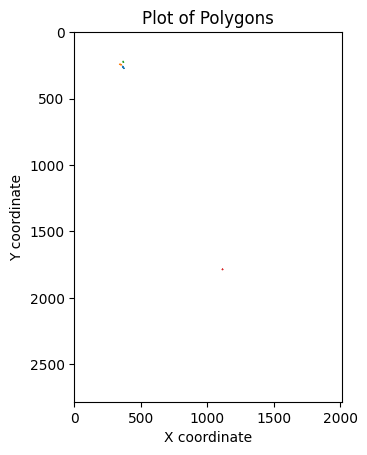

In [ ]:
import matplotlib.pyplot as plt
# Set up the plot
fig, ax = plt.subplots()
for polygon in test:
    # Extract x and y coordinates
    x, y = zip(*polygon)
    ax.plot(x, y, linestyle='-', linewidth=1, marker=None)



# Set plot limits
ax.set_xlim([0, 2014.4667])
ax.set_ylim([0, 2781.7334])
ax.invert_yaxis()  # Inverts the y-axis so that 0 starts at the top


# Add labels and title
ax.set_title('Plot of Polygons')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()